# 2.1 Transit light curve analysis of WASP-12b 

### Universidad de La Laguna Exo & Exo 2024-2025 exercise 2

Author: [Hannu Parviainen](mailto:hannu@iac.es)<br>
Last updated: 21.4.2025

## Initialisation

In [162]:
%matplotlib inline 

In [163]:
import math as mt
import pandas as pd
import warnings
import seaborn as sb

from matplotlib.pyplot import subplots, setp, rc, Rectangle
from numpy import argmax, array, median, seterr, floor, percentile
from numpy.random import seed, permutation
from astropy.table import Table
from corner import corner

from pytransit import TransitLPF

seterr('ignore')
seed(0)

### Read in the data

First we need to read in the light curve stored in ``wasp-12b_181227_chromatic_k.fits``. The file has light curves for a single transit observed simultaneously in four passbands (g, r, i, and z_s), but we keep things simple and use only the r-band data. 

In our case, the photometry is saved as binary table extensions in the fits file, one extension per passband. To get the r-band data, we need to read the third HDU of the fits file (the first is the primary HDU, the second the first extension, etc.).

We start the same way as with the RV data and take a look at our data and try plotting it.

In [164]:
tb = Table.read('data/wasp-12b_181227_chromatic_k.fits', 2)
tb[:5]

time_bjd,flux,flux_rel,flux_trg,flux_ref,baseline,model
float64,float64,float64,float64,float64,float64,float64
2458480.557361179,1.0001350941062013,1.016282780690799,1.0234186998514527,1.0070215881802143,1.0161455054219737,1.0
2458480.558397079,1.0000222850175708,1.0167163747091499,1.0256873377854854,1.0088234667007323,1.0166937176717874,1.0
2458480.5587828704,0.999633046547194,1.0162828378132795,1.0244264276468822,1.0080131136044028,1.016655903207277,1.0
2458480.5594445122,1.0004227218395325,1.0169303171289636,1.0232086525273774,1.0061738108232814,1.016500620116942,1.0
2458480.5602084063,0.9981259684100012,1.0146302762017558,1.021813766379826,1.0070799091516973,1.0165352954577924,1.0


Now, we can assume the time data is stored in the ``time_bjd`` column and the flux the ``flux`` column. In general, if you'd see a file like this, you should check the file's documentation (if such exists) what column is what, or ask the person who created the file.

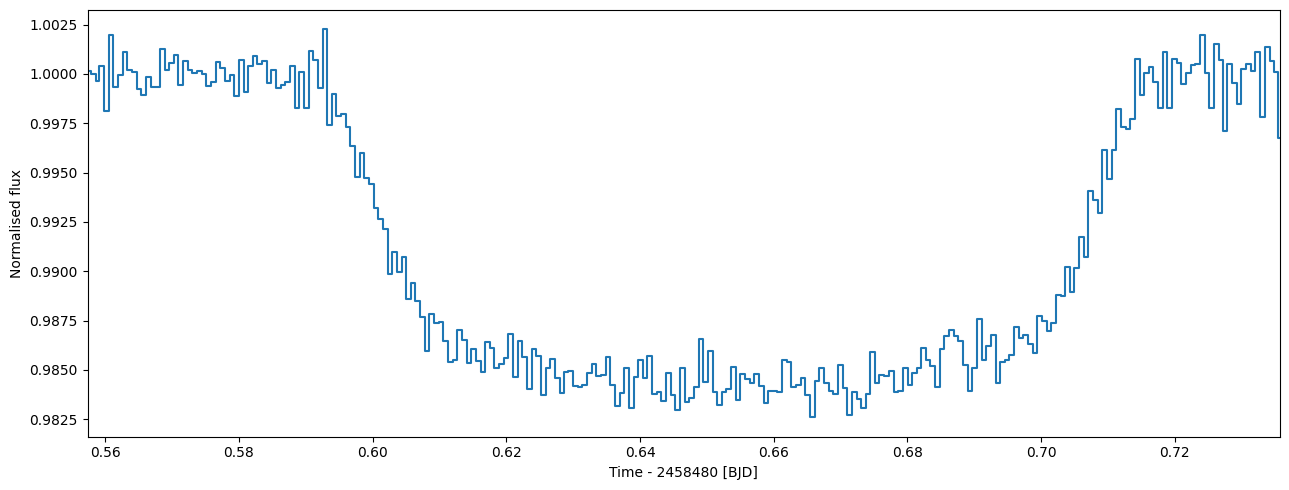

In [165]:
tref = floor(tb['time_bjd'].mean())
fig, ax = subplots(figsize=(13,5), sharey=True)
ax.plot(tb['time_bjd'] - tref, tb['flux'], drawstyle='steps-mid')
setp(ax, xlabel=f"Time - {tref:.0f} [BJD]", ylabel='Normalised flux', xlim=tb['time_bjd'][[0,-1]]-tref)
fig.tight_layout()

## Parameter estimation

First, we create an instance of the log posterior function with the redmost light curve data.

Next, we run the *DE* optimiser for ``de_iter`` iterations to clump the parameter vector population close to the global posterior maximum, use the *DE* population to initialise the *emcee* sampler, and run the sampler for ``mc_iter`` iterations to obtain a posterior sample.

### Initialise the LPF and set the priors

In [166]:
lpf = TransitLPF('WASP-12b', 'r', tb['time_bjd'], tb['flux'])
lpf.ps

[  0 |G| tc             N(μ = 0.0, σ = 0.1)                      [    -inf ..      inf],
   1 |G| p              N(μ = 1.0, σ = 1e-05)                    [    0.00 ..      inf],
   2 |G| rho            U(a = 0.1, b = 25.0)                     [    0.00 ..      inf],
   3 |G| b              U(a = 0.0, b = 1.0)                      [    0.00 ..     1.00],
   4 |P| k2             U(a = 0.0025, b = 0.04)                  [    0.00 ..      inf],
   5 |P| q1_r           U(a = 0, b = 1)                          [    0.00 ..     1.00],
   6 |P| q2_r           U(a = 0, b = 1)                          [    0.00 ..     1.00],
   7 |L| wn_loge_0      U(a = -4, b = 0)                         [    -inf ..      inf]]

In [167]:
lpf.set_prior('tc', 'NP', 2458480.65, 0.02)
lpf.set_prior('p', 'NP', 1.0914201, 1.1e-09)

In [168]:
lpf.ps

[  0 |G| tc             N(μ = 2458480.65, σ = 0.02)              [    -inf ..      inf],
   1 |G| p              N(μ = 1.0914201, σ = 1.1e-09)            [    0.00 ..      inf],
   2 |G| rho            U(a = 0.1, b = 25.0)                     [    0.00 ..      inf],
   3 |G| b              U(a = 0.0, b = 1.0)                      [    0.00 ..     1.00],
   4 |P| k2             U(a = 0.0025, b = 0.04)                  [    0.00 ..      inf],
   5 |P| q1_r           U(a = 0, b = 1)                          [    0.00 ..     1.00],
   6 |P| q2_r           U(a = 0, b = 1)                          [    0.00 ..     1.00],
   7 |L| wn_loge_0      U(a = -4, b = 0)                         [    -inf ..      inf]]

Global optimisation:   0%|          | 0/500 [00:00<?, ?it/s]

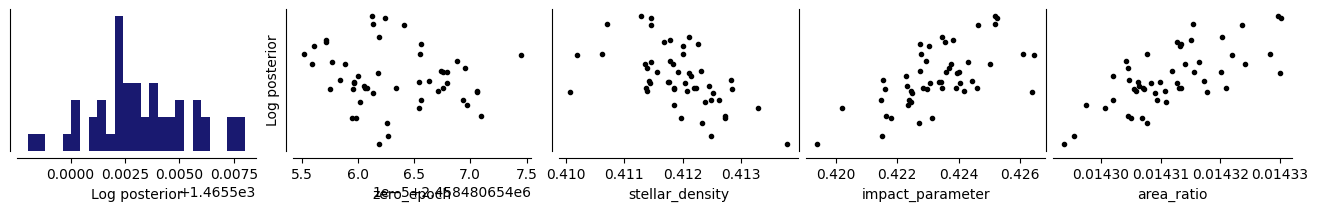

In [169]:
lpf.optimize_global(niter=500, npop=50)

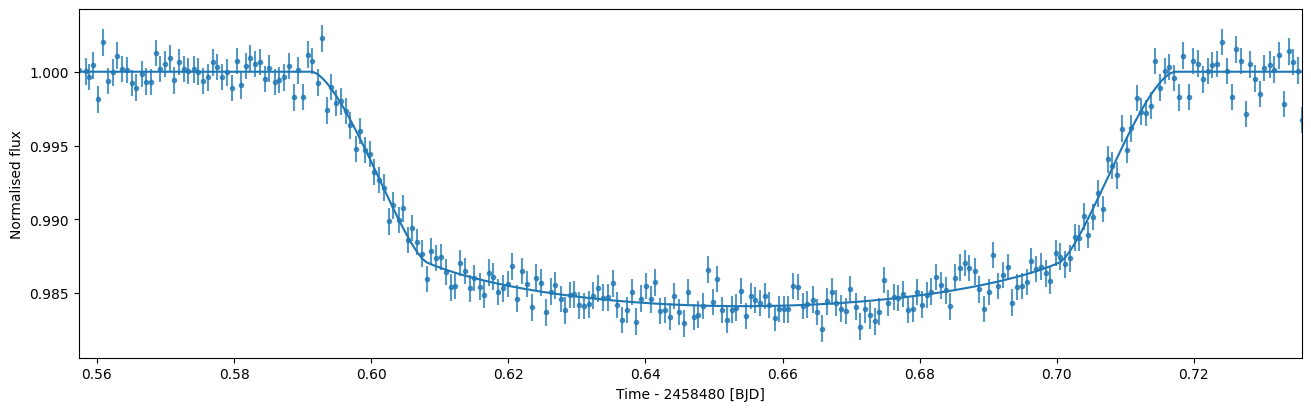

In [170]:
lpf.plot_light_curve();

In [171]:
lpf.sample_mcmc(5000, thin=20, repeats=2, label='MCMC sampling')

MCMC sampling:   0%|          | 0/2 [00:00<?, ?it/s]

Run 1/2:   0%|          | 0/5000 [00:00<?, ?it/s]

Run 2/2:   0%|          | 0/5000 [00:00<?, ?it/s]

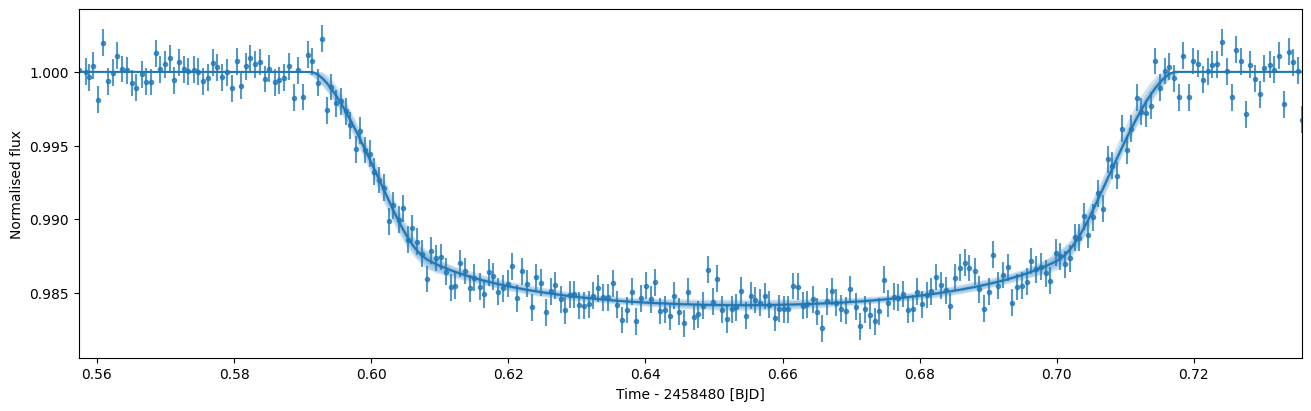

In [172]:
lpf.plot_light_curve('mc');

### Analysis: overview

The MCMC chains are now stored in ``lpf.sampler.chain``. Let's first have a look into how the chain populations evolved to see if we have any problems with our setup, whether we have converged to sample the true posterior distribution, and, if so, what was the burn-in time.

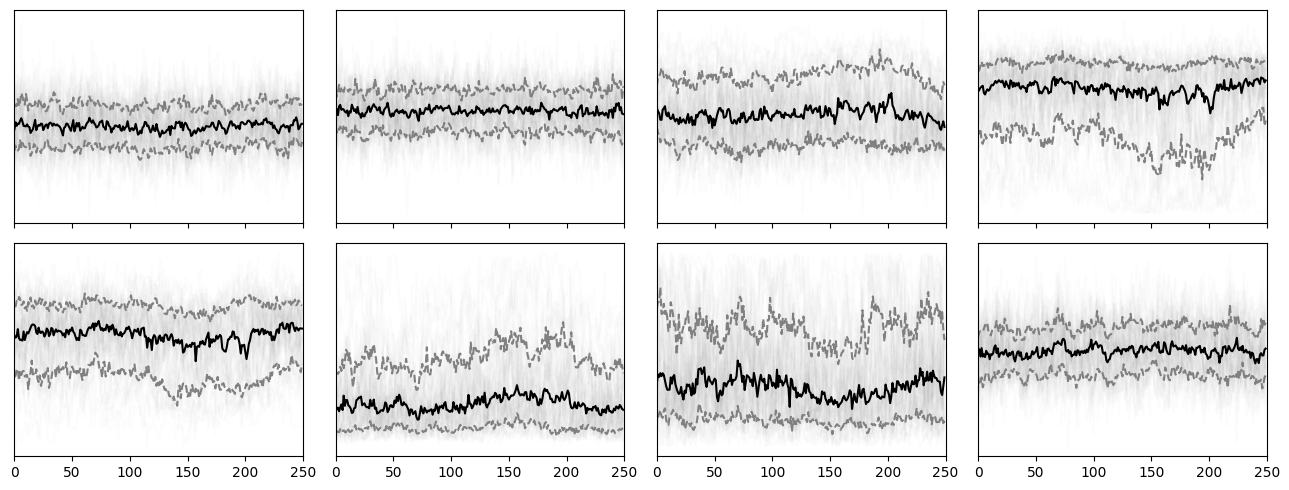

In [173]:
fig, axs = subplots(2,4, figsize=(13,5), sharex=True)
ls, lc = ['-','--','--'], ['k', '0.5', '0.5']
percs = [percentile(lpf.sampler.chain[:,:,i], [50,16,84], 0) for i in range(8)]
[axs.flat[i].plot(lpf.sampler.chain[:,:,i].T, 'k', alpha=0.01) for i in range(8)]
[[axs.flat[i].plot(percs[i][j], c=lc[j], ls=ls[j]) for j in range(3)] for i in range(8)]
setp(axs, yticks=[], xlim=[0,5000//20])
fig.tight_layout()

Ok, everything looks good. The 16th, 50th and 84th percentiles of the parameter vector population are stable and don't show any significant long-term trends. Now we can flatten the individual chains into one long chain ``fc`` and calculate the median parameter vector.

In [174]:
fc = lpf.sampler.chain.reshape([-1,lpf.sampler.chain.shape[-1]])
mp = median(fc, 0)

Let's also plot the model and the data to see if this all makes sense. To do this, we calculate the conditional distribution of flux using the posterior samples (here, we're using a random subset of samples, although this isn't really necessary), and plot the distribution median and it's median-centred 68%, 95%, and 99.7% central posterior intervals (corresponding approximately to 1, 2, and 3$\sigma$ intervals if the distribution is normal). 

In [175]:
flux_pr = lpf.flux_model(fc[permutation(fc.shape[0])[:1000]])
flux_pc = array(percentile(flux_pr, [50, 0.15,99.85, 2.5,97.5, 16,84], 0))

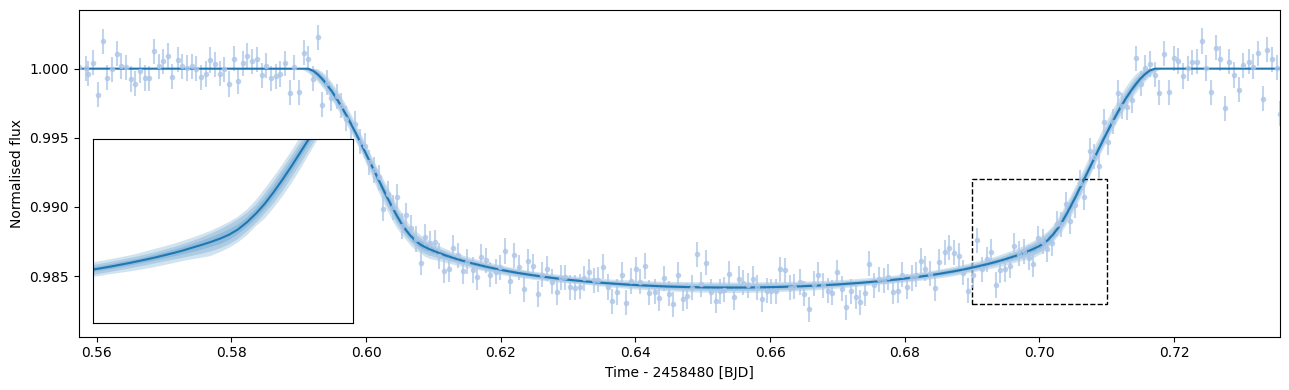

In [176]:
zx1,zx2,zy1,zy2 = 0.69,0.71, 0.983, 0.992
tref = floor(lpf.timea.min())
fig, ax = subplots(1,1, figsize=(13,4))
ax.errorbar(lpf.timea-tref, lpf.ofluxa, 10**mp[7], fmt='.', c='C1', alpha=0.75)
[ax.fill_between(lpf.timea-tref,*flux_pc[i:i+2,:],alpha=0.2,facecolor='C0') for i in range(1,6,2)]
ax.plot(lpf.timea-tref, flux_pc[0], c='C0')
setp(ax, xlim=lpf.timea[[0,-1]]-tref, xlabel=f'Time - {tref:.0f} [BJD]', ylabel='Normalised flux')
fig.tight_layout()

az = fig.add_axes([0.075,0.18,0.20,0.46])
ax.add_patch(Rectangle((zx1,zy1),zx2-zx1,zy2-zy1,fill=False,edgecolor='k',lw=1,ls='dashed'))
[az.fill_between(lpf.timea-tref,*flux_pc[i:i+2,:],alpha=0.2,facecolor='C0') for i in range(1,6,2)]
setp(az, xlim=(zx1,zx2), ylim=(zy1,zy2), yticks=[], xticks=[])
az.plot(lpf.timea-tref, flux_pc[0], c='C0');

We could (should) also plot the residuals, but I've left them out from the plot for clarity. The plot looks fine, and we can continue to have a look at the parameter estimates.

## Analysis

We start the analysis by making a Pandas data frame ``df``, using the ``df.describe`` to gen an overview of the estimates, and plotting the posteriors for the most interesting parameters as violin plots.

In [177]:
pd.set_option('display.precision',4)
df = lpf.posterior_samples(derived_parameters=True)
df.describe()

,tc,p,rho,b,k2,q1_r,q2_r,wn_loge_0,k,a,inc,t14,t23
count,1.2500e+04,1.2500e+04,12500.0000,1.2500e+04,12500.0000,12500.0000,1.2500e+04,12500.0000,12500.0000,12500.0000,12500.0000,12500.0000,12500.0000
mean,2.4585e+06,1.0914e+00,0.4324,3.4389e-01,0.0140,0.3016,3.5976e-01,-3.0405,0.1183,3.0060,1.4549,0.1258,0.0944
std,1.6251e-04,1.1149e-09,0.0374,1.2127e-01,0.0004,0.1890,2.3940e-01,0.0193,0.0019,0.0866,0.0431,0.0010,0.0026
min,2.4585e+06,1.0914e+00,0.3189,7.3673e-05,0.0126,0.0401,3.8756e-05,-3.1138,0.1124,2.7181,1.3552,0.1222,0.0867
25%,2.4585e+06,1.0914e+00,0.4039,2.7914e-01,0.0137,0.1579,1.7004e-01,-3.0540,0.1169,2.9408,1.4227,0.1251,0.0924
50%,2.4585e+06,1.0914e+00,0.4292,3.7710e-01,0.0141,0.2482,3.0598e-01,-3.0407,0.1186,3.0010,1.4449,0.1258,0.0941
75%,2.4585e+06,1.0914e+00,0.4597,4.3409e-01,0.0143,0.3988,5.0604e-01,-3.0278,0.1197,3.0704,1.4799,0.1264,0.0964
max,2.4585e+06,1.0914e+00,0.5353,5.8228e-01,0.0151,0.9994,9.9994e-01,-2.9658,0.1229,3.2303,1.5708,0.1298,0.1018


<Axes: >

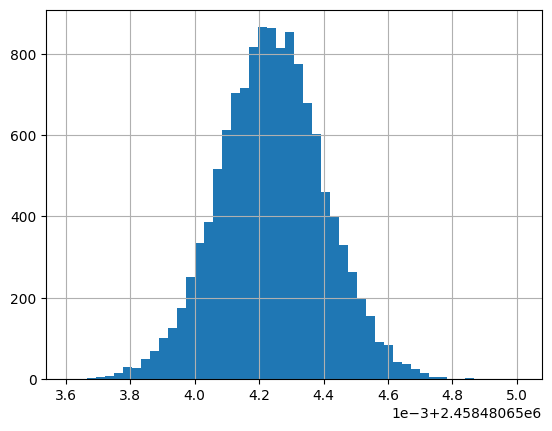

In [178]:
df.tc.hist(bins=50)

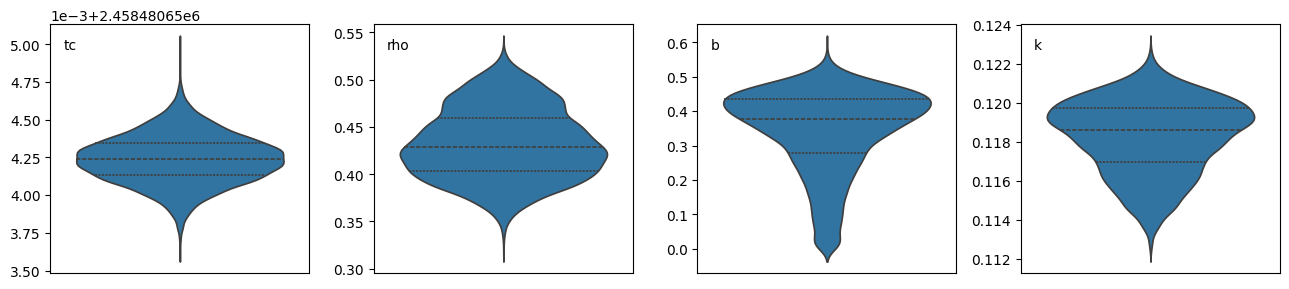

In [179]:
fig, axs = subplots(1,4, figsize=(13,3))
pars = 'tc rho b k'.split()
[sb.violinplot(y=df[p], inner='quartile', ax=axs.flat[i]) for i,p in enumerate(pars)]
[axs.flat[i].text(0.05,0.9, p, transform=axs.flat[i].transAxes) for i,p in enumerate(pars)]
setp(axs, xticks=[], ylabel='')
fig.tight_layout()

While we're at it, let's plot some correlation plots. The limb darkening coefficients are correlated, and we'd also expect to see a correlation between the impact parameter and radius ratio.

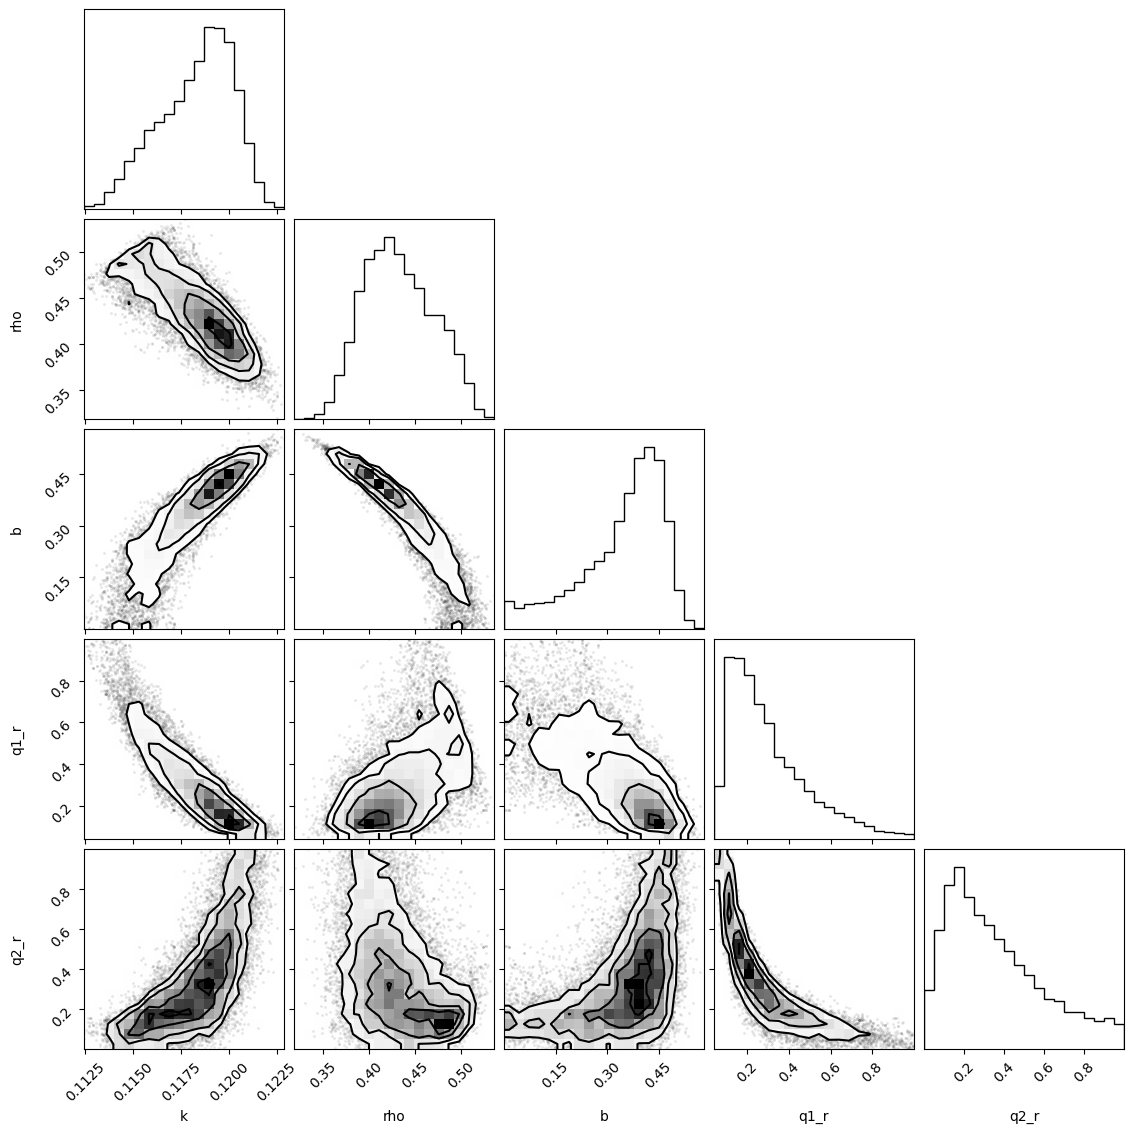

In [180]:
ccols = ['k', 'rho', 'b', 'q1_r', 'q2_r']
corner(df[ccols].values, labels=ccols);

### <span style="color:darkblue">Questions and exercises</span>

1. Estimate the radius of the planet using the planet-star radius ratio (k) and the stellar radius (that you need to find from somewhere) Give the answer in Jupiter radii.

The radius of WASP 12 is found to be equal to 1.657 time the radius of the Sun.

The planet-start radius ratio has been estimated in the previous part; k = (Rp/Rs)

[0.198544   0.19925958 0.19873458 ... 0.19255915 0.19418401 0.19386047] solRad
Rp = 1.9123726292505783 Jupiter radii


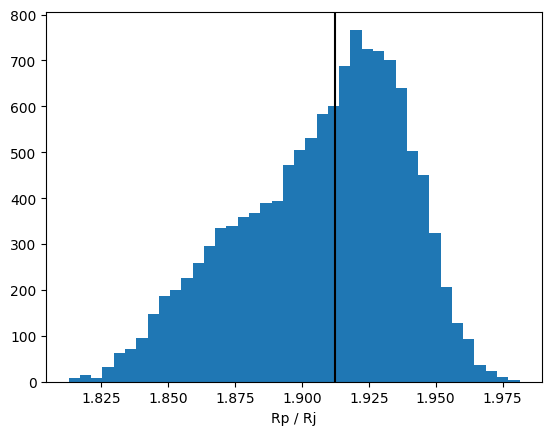

In [181]:
#estimate planet radius in Rj
import numpy as np 
import astropy.units as u


# R_sun = 696192 # in km 
Rs = 1.657 * u.solRad
k = np.array(df["k"])
Rp = Rs*k
print(Rp)

# fig, ax = subplots()
# ax.hist(Rp, bins=40)
# ax.axvline(median(Rp), c='k')
# ax.set_xlabel("Rp [km]")

fig, ax = subplots()
ax.hist(Rp.to(u.jupiterRad), bins=40)
ax.axvline(median(Rp.to(u.jupiterRad).value), c='k')
ax.set_xlabel("Rp / Rj")


print(f"Rp = {median(Rp).to(u.jupiterRad).value} "+"Jupiter radii")


2. Compare the stellar density ($\rho$) estimated from the transit modelling to the theoretical stellar density for a WASP-12-like star.


Plot the histogram of the obtained stellar density.

Text(0.5, 0, 'Stellar density [g/cm^3]')

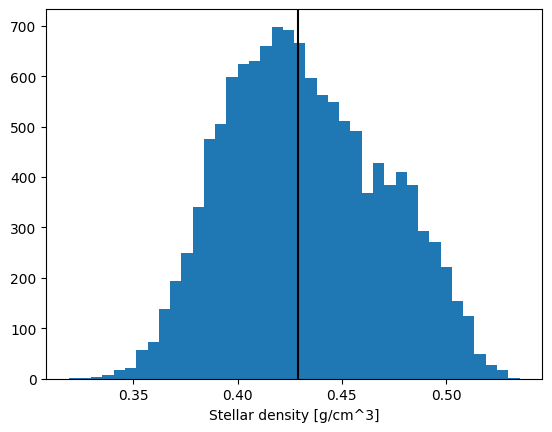

In [182]:
fig, ax = subplots()
ax.hist(df.rho, bins=40)
ax.axvline(median(df.rho), c='k')
ax.set_xlabel("Stellar density [g/cm^3]")

The found estimation for the stellar density lies around 0.44 g/cm^3. 

WASP-12 is a spectral type F star of the later type (F9): from https://www.physics.unlv.edu/~jeffery/astro/star/spectral_type2.html it is found that the mean density corrresponding to these kind of stars is usually higher than what we found, being around 1 or 1.1 g/cm^3. 
This makes WASP-12 an interesting case, having a density lower than the expected one for these kind of stars.

Its peculiarity is probably due to multiple factors, between which we can cite: 
- evolutionary stage: WASP-12 is at the end of the main sequence, it has used most of its hydrogen and its outer layers are expanding. 
- possible effects due to WASP-12b: interactions and tidal effects due to the close-by planet might be causing increased stellar activity and energy dissipation, which leads to an inflation of the outer layers.

So the lower density is mainly due to an inflated radius rather than a lower mass. 

3. From the plot above you can see that many of the parameters are correlated with each other. What does this mean in practice?

Having a correlation between parameters can pose difficulties in the parameter estimation, making it difficult to estimate each parameter and its uncertainties individually. 

Having correlated parameters means that changing one can be 'compensated' by changing the other, leading to minor modifications in the overall output. This implies that the individual parameters estimates can be uncertain and unstable, as multiple combinations of parameters could lead to an equally good fit of the data.

In general parameter correlation can also hinder the convergence of the estimation algorithm. 

During the study of this kind of data the first step is to recognize that the parameters are correlated, and keep it into consideration when analyzng the data. In cases like this, when the calculations are based on the observables, the only way of reducing the correlation, that can be clearly seen in the previous parts of this exercise, is to improve the precision of the data.

Physical interpretation of the parameters and estimation of their influence in the studied phenomenon can become tricky in the case of highly correlated parameters. 


---
<center>&copy;2025 Hannu Parviainen</center>